# NLU for correlate text content across documents

* ***원본 소스는 community 에서 가져왔습니다.***
* ***두군데 수정이 필요한데,,,   python 3 에서 생기는 문제입니다.***
* ***1. print 문에 () 넣기***
* ***2. text1.decode('utf8')   - TypeError: can't use a string pattern on a bytes-like object ***

* ***NLU (Natural Language Understanding) 서비스를 생성하고 아래 화면에서 처럼 credential 을 가져옵니다. ***
* ***만약 credential 이 없다면 새로 생성합니다.***     
![#1](https://github.com/moreal70/IBM-Watson-Studio/raw/master/images/nlu_credential.png)

Text analytics involves getting insights from text content in documents, books, social media, and various other sources. A common requirement is to find the correlation of text content across sources to get a comprehensive picture. This notebook uses Watson Natural Language Understanding (NLU), and Python Natural Language Processing Toolkit (NLTK) in IBM Watson Studio to build a graph of entities with attributes, and uses its relationship with other entities to correlate text content across various sources. The correlation algorithm used in this notebook is driven by an input configuration JSON file that contains the rules and grammar for building the relations. 

1. [The story](#background)<br>
2. [Setup](#setup)<br>
    2.1 [Install required packages](#setup1)<br>
    2.2 [Import packages and libraries](#setup2)<br>
3. [Load Configuration](#conf)<br>
    3.1 [Add your service Natural Language Classifier credentials](#conf1)<br>
    3.2 [Add Data](#conf2)<br>
    3.3 [Add your service credentials for Object Storage](#conf3)<br>
    3.4 [Global Variables](#conf4)<br>
    3.5 [Configure and download required NLTK packages](#conf5)<br>
4. [Correlation](#corr)<br>
    4.1 [Watson NLU API](#corr1)<br>
    4.2 [Augumented Correlation](#corr2)<br>
    4.3 [Correlated Network Visualization](#corr3)<br>
5. [Read Data](#store)<br>
    5.1 [Configure Object Storage Client](#store1)<br>
    5.2 [Get Data](#store2)<br>
6. [Correlate text](#corr-text)<br>
7. [Visualize correlated text](#vis)<br>   

<a id='background'></a>
## The story
It is important to correlate the text content across documents in order to obtain actionable insights. In this notebook, we are showing you a methodology to correlate the text content across documents in a configurable way.

The correlation algorithm is driven by an input configuration JSON file that contains the rules and grammar for building the relations. This JSON configuration file can be prepared by a domain expert and can be modified in order to obtain better correlation results between the text content across documents. The configuration and input documents are stored in IBM Object Storage.

### The configuration file
Let's look at the input configuration file required by the algorithm.

The input configuration file is divided into two categories: 
1. coreference, and
2. relations.

In the `coreference` section, we specify the patterns to identify all the personal pronouns and the proper noun names in the text content. In the `relations` section, we specify regular expression patterns that can be used to infer the relationship between entities.

Here is what part of the configuration file looks like:

```
{
  "configuration": {
    "coreference": {
      "rules": [
        {
          "type": "chunking",
          "chunk": [
            {
              "tag": "PRP",
              "type": "coreference",
              "pattern": "PRP:{<PRP>+}"
            },
            {
              "tag": "NAME",
              "type": "reference",
              "pattern": "NAME:{<NNP>+}"
            }
          ]
        }
      ]
    },
    "relations": {
      "rules": [
        {
          "type": "d_regex",
          "d_regex": [
            {
              "tag": "BornAt",
              "pattern": ".*(<Person:.*?>).*(born|born at| born in).*(<Location:.*?>).*"
            }
          ]
        },
```

### Example
Let's take one example to understand how it works.

#### The bornAt relationship 
For the bornAt relationship, the regular expression pattern that is specified is if a person is followed by `born` or `born at` or `born in`, and then is followed by a location then we infer that it is a bornAt relationship between the person and the location.

#### Text categorization
The text categorization such as person or location is obtained from the pattern natural language understanding. 

#### Relationships
Similarly, we have specified the different regular expression patterns to identify the relationships that we are 
interested in in the text content.


### The input documents we want to analyze
To demonstrate the output from the algorithm we have selected two documents: 
1. The first document contains information about the former president of the United States, Barack Hussein Obama. 
2. The second document contains information about Michelle Obama. 

Now let's set up our environment so that we can look at the output from the correlational algorithm based on the input configuration file that we have specified.


<a id='setup'></a>
## 2. Setup

<a id='setup1'></a>
### 2.1 Install required packages 

You need the latest versions of these packages:<br>
- **Watson Developer Cloud**: a client library for Watson services.<br>
- **NLTK**: leading platform for building Python programs to work with human language data.<br>

** Install the Watson Developer Cloud package: **

In [4]:
!pip install  --upgrade watson-developer-cloud

Requirement already up-to-date: watson-developer-cloud in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: python-dateutil>=2.5.3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement not upgraded as not directly required: requests<3.0,>=2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement not upgraded as not directly required: autobahn>=0.10.9 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement not upgraded as not directly required: Twisted>=13.2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement not upgraded as not directly required: service-identity>=17.0.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement not upgraded as not directly required: pyOpenSSL>=16.2.0 in /opt/con

** Install NLTK: **

In [3]:
!pip install --upgrade nltk

Requirement already up-to-date: nltk in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from nltk)


** <font color=blue>Now restart the kernel by choosing Kernel > Restart. </font> **

<a id='setup2'></a>
### 2.2 Import packages and libraries

* ***python 3 버전에서는 thread 모듈 이름이 바뀌었네요.***    수정  _thread

In [6]:
import json
import sys
import _thread
import time
import watson_developer_cloud
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 \
  import Features, EntitiesOptions, KeywordsOptions,SemanticRolesOptions
    
import ibm_boto3
from botocore.client import Config
    
import operator
from functools import reduce
from io import StringIO
import numpy as np
from os.path import join, dirname
import requests
import re
import pandas as pd
import nltk
from nltk.cluster.util import cosine_distance
from nltk import word_tokenize,sent_tokenize,ne_chunk
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt
import numpy

<a id='conf'></a>
## 3. Configuration


<a id='conf1'></a>
### 3.1 Add your service Natural Language Classifier credentials

1. Retrieve your Watson Natural Language Understanding (NLU) credentials by going to **Services -> Watson Services** in the main tool bar. If you don't already have an NLU instance, click on **Add Service** and select **Natural Language Classifier**.

2. Once you have the NLU service provisioned, click on credentials. Your credentials will have the following format:
```{
     "url": "https://gateway.watsonplatform.net/natural-language-understanding/api",
     "username": "<your username>",
     "password": "<your password>",
}
```

3. Insert the username and password values for your NLU in the following cell. Do not change the values of the version fields.

Run the cell.

In [9]:
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2017-02-27',
    username="xb5fbe544-8177-44d9-a049-b6c7a3150839x",    # masking 된 것임, 본인 것으로 수정 요망
    password="ypE4YQSAVbvi")

<a id='conf3'></a>
### 3.2 Add Data



Add the data and configuration files to the notebook.

1. Go to <a href="https://github.com/IBM/watson-document-co-relation" target="_blank" rel="noopener noreferrer">watson-document-co-relation</a>, and
 - navigate to the `/data/` directory and download `sample_text_1.txt` and `sample_text_2.txt`, 
 - navigate to `/configuration/` and download `sample_config.txt`.

  **Note:** It is possible to use your own data and configuration files. If you use a configuration file from your computer, make sure to conform to the JSON structure given in configuration/sample_config.txt
  
2. Load the data files to the notebook by clicking the **Data** button on the notebook action bar. Drag and drop the file into the box or click browse to select the file from your directory. The file is loaded to your object storage and also appears in the Data Assets section of your project.

    
    


<a id='conf2'></a>
### 3.3 Add your service credentials for Object Storage

To access data in a file in IBM Cloud Object Storage, you need the Object Storage authentication credentials. 

To insert your credentials: 
1. Click on the empty cell below.
2. Select the **Data** tab to display the files you uploaded to your project.
3. Select **Insert to code -> Insert Credentials** that you see just below one of your files for this project. This will insert your credentials.
4. Ensure that the credentials are saved as `credentials_1`.
5. Run the cell.


In [18]:
# The code was removed by DSX for sharing.

<a id='conf4'></a>
### 3.4 Global Variables

Let's define some global variables. Again, note that if you've used your own data and configuration files, you'll want to ensure the file names below are replaced with the filenames you've chosen to import.


In [19]:
# Specify file  for sample text and configuration files
sampleTextFileName1 = "sample_text_1.txt"
sampleTextFileName2 = "sample_text_2.txt"
sampleConfigFileName = "sample_config.txt"

# Maintain tagged text and plain text map
tagTextMap ={}

# Stop words
nltk.download('stopwords')
stopWords = stopwords.words('english')
# Additional words to be ignored 
stopWords.extend(["The","This","That",".","!","?"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id='conf5'></a>
### 3.5 Configure and download required NLTK packages

Download the 'punkt' and 'averaged_perceptron_tagger' NLTK packages for POS tagging usage.

In [20]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/dsxuser/nltk_data...
[nltk_data]   Package words is already up-to-date!


<a id='corr'></a>
## 4. Correlation

Write the correlation related utility functions in a modularalized form.

<a id='corr1'></a>
### 4.1 Watson NLU API

In [21]:
# Analyze features of natural language content.

def analyze_using_NLU(analysistext):
    response = natural_language_understanding.analyze( 
        text=analysistext,
        features=Features(entities=EntitiesOptions(), 
                          keywords=KeywordsOptions(),
                          semantic_roles=SemanticRolesOptions()))

    return response

<a id='corr2'></a>
### 4.2 Augumented Correlation

Custom correlation utlity functions for augumenting the results of Watson NLU API call.

In [22]:
def split_sentences(text):
    """ Split text into sentences.
    """
    sentence_delimiters = re.compile(u'[\\[\\]\n.!?]')
    sentences = sentence_delimiters.split(text)
    return sentences

def split_into_tokens(text):
    """ Split text into tokens.
    """
    tokens = nltk.word_tokenize(text)
    return tokens
    
def POS_tagging(text):
    """ Generate Part of speech tagging of the text.
    """
    POSofText = nltk.tag.pos_tag(text)
    return POSofText

def keyword_tagging(tag,tagtext,text):
    """ Tag the text matching keywords.
    """
    if (text.lower().find(tagtext.lower()) != -1):
        return text[text.lower().find(tagtext.lower()):text.lower().find(tagtext.lower())+len(tagtext)]
    else:
        return 'UNKNOWN'
    
def regex_tagging(tag,regex,text):
    """ Tag the text matching REGEX.
    """    
    p = re.compile(regex, re.IGNORECASE)
    matchtext = p.findall(text)
    regex_list=[]    
    if (len(matchtext)>0):
        for regword in matchtext:
            regex_list.append(regword)
    return regex_list

def chunk_tagging(tag,chunk,text):
    """ Tag the text using chunking.
    """
    parsed_cp = nltk.RegexpParser(chunk)
    pos_cp = parsed_cp.parse(text)
    chunk_list=[]
    for root in pos_cp:
        if isinstance(root, nltk.tree.Tree):               
            if root.label() == tag:
                chunk_word = ''
                for child_root in root:
                    chunk_word = chunk_word +' '+ child_root[0]
                chunk_list.append(chunk_word)
    return chunk_list
    
def augument_NLUResponse(responsejson,updateType,text,tag):
    """ Update the NLU response JSON with augumented classifications.
    """
    if(updateType == 'keyword'):
        if not any(d.get('text', None) == text for d in responsejson['keywords']):
            responsejson['keywords'].append({"text":text,"relevance":0.5})
    else:
        if not any(d.get('text', None) == text for d in responsejson['entities']):
            responsejson['entities'].append({"type":tag,"text":text,"relevance":0.5,"count":1})        
    
def chunk_sentence(text):
    """ Tag the sentence using chunking.
    """
    grammar = """
      NP: {<DT|JJ|PRP|NN.*>+} # Chunk sequences of DT,JJ,NN
          #}<VB*|DT|JJ|RB|PRP><NN.*>+{  # Chink sequences of VB,DT,JJ,NN       
      PP: {<IN><NP>}               # Chunk prepositions followed by NP
      V: {<V.*>}                   # Verb      
      VP: {<VB*><NP|PP|CLAUSE>+}  # Chunk verbs and their arguments
      CLAUSE: {<NP><VP>}           # Chunk NP, VP
      """  
    parsed_cp = nltk.RegexpParser(grammar,loop=2)
    pos_cp = parsed_cp.parse(text)
    return pos_cp
    
def find_attrs(subtree,phrase):
    attrs = ''
    if phrase == 'NP':
        for nodes in subtree:
            if nodes[1] in ['DT','PRP$','POS','JJ','CD','ADJP','QP','NP','NNP']:
                attrs = attrs+' '+nodes[0]
    return attrs    
    
def find_subject(t):
    for s in t.subtrees(lambda t: t.label() == 'NP'):
        return find_attrs(s,'NP')
    
def resolve_coreference(text, config):
    """ Resolve coreferences in the text for Nouns that are Subjects in a sentence
    """
    sentenceList = split_sentences(text)
    referenceSubject = ''
    sentenceText = ''
    configjson = json.loads(config)
    
    for sentences in sentenceList:    
        tokens = split_into_tokens(sentences)   
        postags = POS_tagging(tokens)
        sentencetags = chunk_sentence(postags)
        subjects = find_subject(sentencetags)
        for rules in configjson['configuration']['coreference']['rules']:
            if (rules['type'] == 'chunking'):
                for tags in rules['chunk']:
                    chunktags = chunk_tagging(tags['tag'],tags['pattern'],postags)
                    if (len(chunktags)>0):
                        for words in chunktags:
                            if tags['tag'] == 'PRP':
                                if subjects == '':
                                    sentenceText = sentenceText+sentences.replace(words,referenceSubject)+'. '
                            elif tags['tag'] == 'NAME':
                                if words == subjects:
                                    referenceSubject = words
                                    sentenceText = sentenceText+sentences+'. '
                    
    return sentenceText

def disambiguate_entities(text):
    """ Resolve disambiguity in the text using entities and entity resolution performed using Watson NLU
    """    
    sentenceList = split_sentences(text)
    taggedtext = text
    response = analyze_using_NLU(text)
    responsejson = response
    for sentences in sentenceList:
        tokens = split_into_tokens(sentences)
        postags = POS_tagging(tokens)
        name_tagged_text = chunk_tagging('NAME','NAME:{<NNP>+}',postags)
        print(name_tagged_text)
    for entities in responsejson['entities']:
        regexstr = entities['text']+'(?!>)'
        regex = re.compile(regexstr, re.IGNORECASE)
        tagText = '<'+entities['type']+':'+entities['text']+'>'
        taggedtext = re.sub(regexstr,tagText,taggedtext)
        tagTextMap[tagText] = entities['text']
    
    for roles in responsejson['semantic_roles']:
        if 'entities' not in roles['subject']:
            print('NO ENTITY')
        else:
            for entity in roles['subject']['entities']:
                if 'disambiguation' not in entity:
                    print('NO DISAMBIGUATION')
                else:
                    regexstr = roles['subject']['text']+'(?!>)'
                    regex = re.compile(regexstr, re.IGNORECASE)
                    tagText = '<'+entity['type']+':'+entity['text']+'>'
                    taggedtext = re.sub(regexstr,tagText,taggedtext)
                    tagTextMap[tagText] = entity['text']
    
    return taggedtext

def extract_relations(text, config,relations):
    """ Extract entity relationships in a sentence
    """    
    sentenceList = split_sentences(text)
    configjson = json.loads(config)
     
    for sentences in sentenceList:
        for rules in configjson['configuration']['relations']['rules']:
            if (rules['type'] == 'd_regex'):
                for regex in rules['d_regex']:
                    regextags = regex_tagging(regex['tag'],regex['pattern'],sentences)
                    if (len(regextags)>0):
                        for words in regextags:
                            relations.append((tagTextMap[words[0]],regex['tag'],tagTextMap[words[2]]))
         
    return relations

def compute_text_similarity(text1, text2, text1tags, text2tags):
    """ Compute text similarity using cosine
    """
    sentences_text1 = split_sentences(text1)
    sentences_text2 = split_sentences(text2)
    tokens_text1 = []
    tokens_text2 = []
    
    for sentence in sentences_text1:
        tokenstemp = split_into_tokens(sentence.lower())
        tokens_text1.extend(tokenstemp)
    
    for sentence in sentences_text2:
        tokenstemp = split_into_tokens(sentence.lower())
        tokens_text2.extend(tokenstemp)
    # Add text tags    
    if (len(text1tags) > 0):  
        tokens_text1.extend(text1tags)
    if (len(text2tags) > 0):    
        tokens_text2.extend(text2tags)
    
    # Stem words
    tokens1Filtered = [stemmer.stem(x) for x in tokens_text1 if x not in stopWords]
    tokens2Filtered = [stemmer.stem(x) for x in tokens_text2 if x not in stopWords]
    
    #  remove duplicate tokens
    tokens1Filtered = set(tokens1Filtered)
    tokens2Filtered = set(tokens2Filtered)
   
    tokensList=[]

    text1vector = []
    text2vector = []

    if len(tokens1Filtered) < len(tokens2Filtered):
        tokensList = tokens1Filtered
    else:
        tokensList = tokens2Filtered

    for token in tokensList:
        if token in tokens1Filtered:
            text1vector.append(1)
        else:
            text1vector.append(0)
        if token in tokens2Filtered:
            text2vector.append(1)
        else:
            text2vector.append(0)  

    cosine_similarity = 1-cosine_distance(text1vector,text2vector)
    if numpy.isnan(cosine_similarity):
        cosine_similarity = 0
    
    return cosine_similarity

<a id='corr3'></a>
### 4.3 Correlated Network Visualization

Utility function to plot network visualization of entity relationships to correlate them.

In [23]:
def draw_simple_graph(graph):

    nodes = []
    labels = []
    edges = []
    # extract nodes from graph
    for tuples in graph:
        nodes.append(tuples[0])
        nodes.append(tuples[2])
        
    # extract edges from graph
    for edgepairs in graph:
        edges.append((edgepairs[0],edgepairs[2]))        
    # extract edge labels from graph
    for edgetuples in graph:
        labels.append(edgetuples[1])
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[2])

    # draw graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos,with_labels = True)
    edge_labels = dict(zip(edges, labels))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)

    # show graph
    plt.show()    

<a id='store'></a>
## 5. Read Data

<a id='store1'></a>
### 5.1 Configure Object Storage Client

In [24]:
cos = ibm_boto3.client('s3',
                    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                    config=Config(signature_version='oauth'),
                    endpoint_url=credentials_1['ENDPOINT'])

def get_file(filename):
    '''Retrieve file from Cloud Object Storage'''
    fileobject = cos.get_object(Bucket=credentials_1['BUCKET'], Key=filename)['Body']
    return fileobject

def load_string(fileobject):
    '''Load the file contents into a Python string'''
    text = fileobject.read()
    return text

<a id='store2'></a>
### 5.2. Get Data
Read the data and configuration files for correlation from IBM Cloud Object Storage. 


In [31]:
text1 = load_string(get_file(sampleTextFileName1)).decode('utf8')
text2 = load_string(get_file(sampleTextFileName2)).decode('utf8')
config = load_string(get_file(sampleConfigFileName)).decode('utf8')
relationships = []

In [29]:
text1.decode('utf8')

'Barack Hussein Obama II  born August 4, 1961 is an American politician who served as the 44th President of the United States from 2009 to 2017. He previously served in the U S Senate representing Illinois from 2005 to 2008 and in the Illinois State Senate from 1997 to 2004.\n'

In [32]:
resolved_text1 = resolve_coreference(text1, config)
resolved_text2 = resolve_coreference(text2, config)

disambiguated_text1 = disambiguate_entities(resolved_text1)
disambiguated_text2 = disambiguate_entities(resolved_text2)

extract_relations(disambiguated_text1, config,relationships)
extract_relations(disambiguated_text2, config,relationships)

[' Barack Hussein Obama II', ' August', ' President', ' United']
[' Barack Hussein Obama II', ' U S Senate', ' Illinois', ' Illinois State Senate']
[]
NO ENTITY
NO ENTITY
NO ENTITY
NO ENTITY
NO ENTITY
[' Michelle Obama', ' January', ' Chicago', ' Illinois']
[' Michelle Obama', ' Princeton University', ' Harvard Law School']
[' Michelle Obama', ' Barack Hussein Obama']
[]
NO ENTITY
NO ENTITY
NO ENTITY
NO ENTITY
NO ENTITY
NO ENTITY


[('Barack Hussein Obama', 'BornAt', 'United States'),
 ('Barack Hussein Obama', 'ServedAt', 'Senate'),
 ('Barack Hussein Obama', 'RepresentiveFor', 'Illinois'),
 ('Michelle Obama', 'BornAt', 'Illinois'),
 ('Michelle Obama', 'SpouseOf', 'Barack Hussein Obama')]

<a id='corr-text'></a>
## 6. Correlate text

In [33]:
print ("Document similarity score")
print (compute_text_similarity(text1,text2,[],[]))
print ("")
print ("Entities and relations:")
print (relationships)

Document similarity score
0.480384461415

Entities and relations:
[('Barack Hussein Obama', 'BornAt', 'United States'), ('Barack Hussein Obama', 'ServedAt', 'Senate'), ('Barack Hussein Obama', 'RepresentiveFor', 'Illinois'), ('Michelle Obama', 'BornAt', 'Illinois'), ('Michelle Obama', 'SpouseOf', 'Barack Hussein Obama')]


<a id='vis'></a>
## 7. Visualize correlated text

Plot network graph of the correlated text.

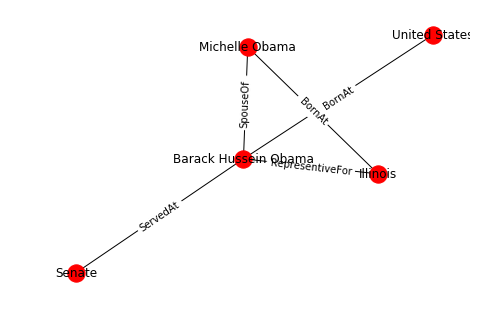

In [34]:
draw_simple_graph(relationships)

As you can see, all the entities and relationships have been identified.

You can go ahead and enhance the algorithm as well as the input configuration file to get better results for the specific scenario that you are working on.

### Author 
**Vishal Chahal** is the Chief Architect for Cognitive Solutions at System Integrators lab and also the Technical Lead for IBM Machine Learning Hub at IBM Software Labs in Bangalore. 

Balaji Kadambi is a Solution Architect at System Integrators Lab working on Watson Cognitive Products.


Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.